In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from urbana.constants import DIR_REPO, DIR_DATA

In [2]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

MIN_LISTINGS_PER_NEIGHBOURHOOD = 20

ACTIVATE_THRESHOLD = False

In [3]:
neigh = pd.read_csv(
    DIR_DATA / "interim/neigh.csv",
)

neigh.set_index("N_neighbourhood", inplace=True)

neigh.drop(['N_district', 'Neighbourhood', 'District'], axis=1, inplace=True)

if ACTIVATE_THRESHOLD:
    neigh = neigh[neigh['Airbnb_Number'] > MIN_LISTINGS_PER_NEIGHBOURHOOD]

neigh

,Mean_Income_Year,Population_Female,Population_0_15,Population_16_25,Population_26_65,Population_66_Plus,POI_Daily_Food,POI_Daily_Others,POI_House_Equipment,POI_Clothing,...,Nationality_Bangladesh,Nationality_Georgia,Nationality_Armenia,Nationality_Japan,Nationality_Nepal,Nationality_Oceania,Rent_Number,Rent_Price,Rent_Price_Area,Rent_Area
N_neighbourhood,,,,,,,,,,,,,,,,,,,,,
1,9001.176987,0.458032,0.136511,0.112985,0.637792,0.112712,484,81,84,191,...,0.059717,0.001302,0.000924,0.000840,0.003088,0.000693,2003,748.579486,13.915648,59.218221
2,11978.842548,0.479890,0.089155,0.115365,0.665235,0.130245,106,74,46,443,...,0.006226,0.001806,0.000560,0.002490,0.000872,0.002117,808,973.270161,14.191885,77.628242
3,11548.549280,0.502867,0.089891,0.101160,0.631635,0.177314,101,20,8,25,...,0.001000,0.000600,0.000533,0.000734,0.001400,0.002134,857,745.814714,19.844592,40.104113
4,12657.310286,0.502267,0.103473,0.104353,0.655561,0.136614,210,56,52,284,...,0.001981,0.002025,0.000352,0.003037,0.000264,0.002069,1309,916.652697,15.713611,66.137255
5,16376.465455,0.529798,0.122314,0.092454,0.581928,0.203305,136,53,72,58,...,0.001093,0.001000,0.000312,0.000781,0.000718,0.000281,1054,900.418197,13.114796,74.004119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,17323.097293,0.508475,0.205077,0.065962,0.588304,0.140656,36,22,7,74,...,0.000000,0.000660,0.000660,0.000660,0.000000,0.000367,394,1092.062970,16.031175,94.374172
70,9605.617715,0.495241,0.153201,0.103481,0.570386,0.172932,106,24,11,12,...,0.001043,0.002564,0.001173,0.000087,0.002651,0.000043,354,613.031243,10.031687,62.358974
71,14038.842876,0.517645,0.148631,0.090887,0.591204,0.169278,34,24,13,8,...,0.000098,0.001757,0.001025,0.000049,0.000537,0.000049,427,932.015902,12.935797,72.045213


# Train and Test

In [4]:
X = neigh.loc[:, neigh.columns != 'Airbnb_Number']
y = neigh['Airbnb_Number']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

## Fit a pipeline with "IterativeImputer", "StandardScaler" and "LinearRegression"

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


pipe = Pipeline([
    ('imputer',IterativeImputer()),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', IterativeImputer()), ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [6]:
y_train_pred = pipe.predict(X_train)
mae_train = median_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

y_test_pred = pipe.predict(X_test)
mae_test = median_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

train_test_metrics = {'Train': [mae_train, mse_train, r2_train], 'Test': [mae_test, mse_test, r2_test]}
train_test_metrics = pd.DataFrame(data=train_test_metrics)
train_test_metrics.index=list(['MAE', 'MSE', 'R2'])
train_test_metrics

,Train,Test
MAE,3.410605e-13,134.260445
MSE,2.969427e-25,381162.303025
R2,1.000000e+00,-1.233161


## Visualize coefficients

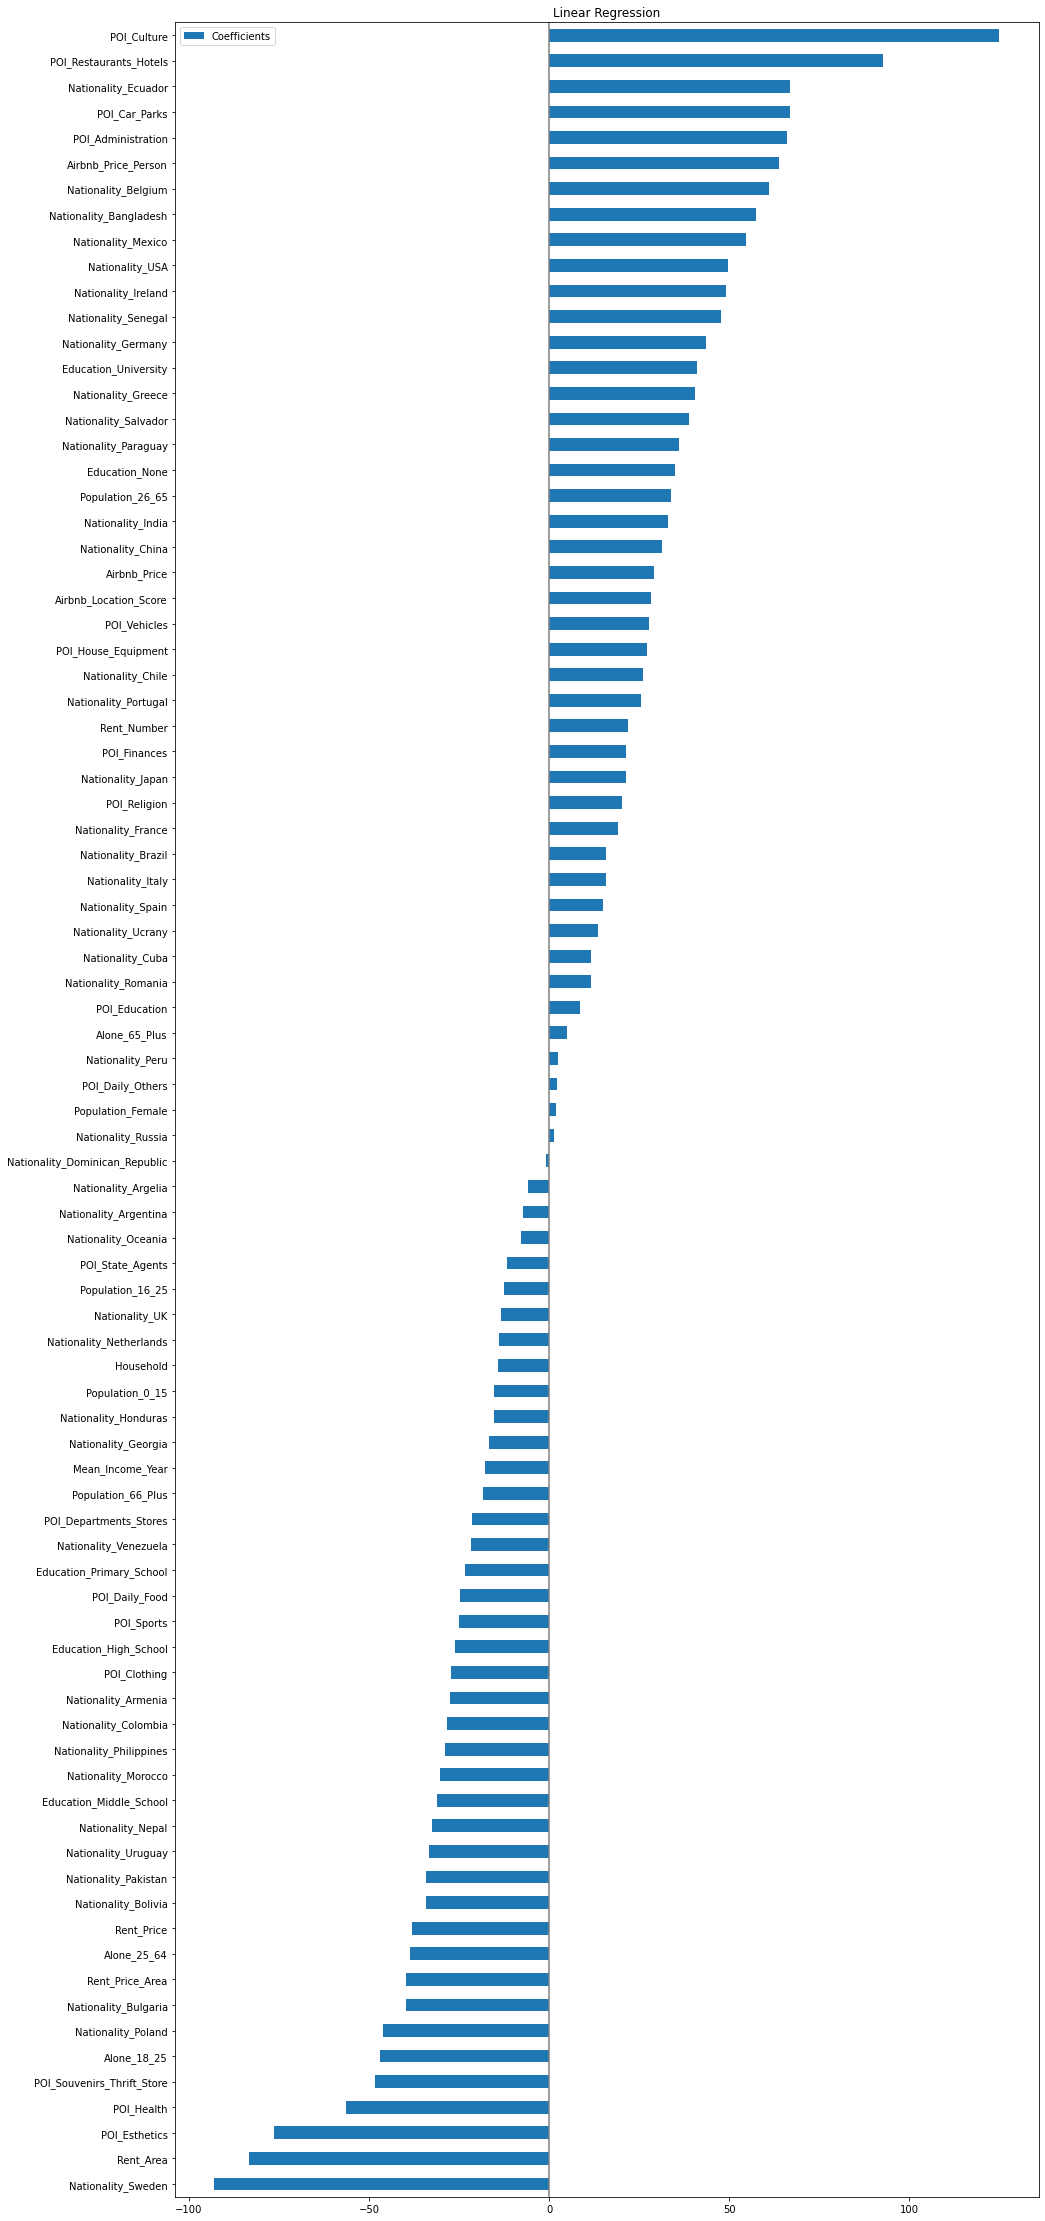

In [7]:
coefs = pd.DataFrame(
    pipe.named_steps['regressor'].coef_,
    columns=['Coefficients'], index=X_train.columns
)

coefs.sort_values(by=['Coefficients'],inplace=True)

coefs.plot(kind='barh', figsize=(20, 40))
plt.title('Linear Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# plt.savefig('coefficients.jpg')

# Cross-Validation

## Sensibility Analysis

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_pipe = cross_validate(
    pipe, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=['neg_median_absolute_error', 'neg_mean_squared_error', 'r2'],
    return_estimator=True, n_jobs=-1
)

In [9]:
new_coefs = pd.DataFrame(
    [est.named_steps['regressor'].coef_ for est in cv_pipe['estimator']],
    columns=X_train.columns
)

new_coefs = new_coefs[coefs.index]

new_coefs

,Nationality_Sweden,Rent_Area,POI_Esthetics,POI_Health,POI_Souvenirs_Thrift_Store,Alone_18_25,Nationality_Poland,Nationality_Bulgaria,Rent_Price_Area,Alone_25_64,...,Nationality_USA,Nationality_Mexico,Nationality_Bangladesh,Nationality_Belgium,Airbnb_Price_Person,POI_Administration,POI_Car_Parks,Nationality_Ecuador,POI_Restaurants_Hotels,POI_Culture
0,-42.296734,-56.556409,-146.462885,-171.254356,54.105244,-55.974771,-40.809123,-32.686203,-29.793698,-53.285538,...,-46.951951,-25.316478,-2.823930,-0.212133,22.720925,29.961169,143.716568,-11.608488,141.115332,73.415112
1,-59.477137,-3.271532,-145.548224,-66.554553,95.587319,-144.040100,19.491552,-28.453161,-33.605753,-90.936517,...,-9.992210,7.895015,-13.456331,32.954595,-24.554278,6.887297,13.341632,67.888338,95.590052,98.881470
2,-39.321871,11.813711,-9.501923,-76.149645,70.647486,10.379684,-15.330231,-29.583307,-14.910182,-10.377594,...,29.601065,49.198997,-10.424140,51.923330,14.468694,-9.848700,81.964813,36.513182,57.089261,46.239033
3,-75.597458,11.465302,-45.500759,-24.573790,-43.405341,9.755197,-41.491367,-34.386082,-75.704814,-51.985248,...,4.739016,8.472297,48.523054,61.876185,14.702974,136.830076,9.074294,30.558727,79.561437,65.838967
4,-14.236504,-35.173009,-114.803512,-15.961206,67.882197,-0.468088,-68.641483,-37.785209,-28.973724,-84.903776,...,-22.350747,10.414571,-33.607367,1.076481,-17.883576,2.225034,56.445190,-24.950637,31.147441,50.078143
5,-31.808674,-17.271609,-52.187000,-24.309840,-20.101523,-4.426593,-44.168991,-13.159242,-67.225359,-83.478055,...,-0.714902,-50.653252,-37.216716,-4.605217,32.100073,5.146803,42.650399,7.549372,82.089700,45.472294
6,-124.863652,-72.904998,-162.150557,-88.693027,70.541354,-94.568841,-45.278509,-15.989677,8.115296,-27.640720,...,33.150492,4.446925,15.601236,24.194571,43.042603,39.731007,67.708797,-10.047189,97.149978,81.432058
7,-86.673700,-45.793788,-83.416406,-84.406387,94.645350,-76.965421,-22.937918,-33.751472,-45.017129,-52.787041,...,38.413218,-18.095857,-34.432120,-18.517758,-16.568003,70.348263,-23.843155,42.962833,109.842237,108.963957
8,-97.680067,-45.901955,-131.356855,-92.101252,22.485701,-34.225416,-34.540536,-59.427766,-23.458443,-53.481487,...,-40.439928,107.507766,12.203671,39.491300,60.228120,-2.333758,6.870423,66.879262,91.622084,156.663686
9,-6.600109,24.116213,-31.809081,-162.337303,95.194507,-43.851718,-47.134552,-54.948395,-16.122706,-84.037188,...,8.026991,8.019215,-34.553383,91.519106,-41.244983,32.842689,84.408024,39.129046,104.324773,60.293826


<AxesSubplot:>

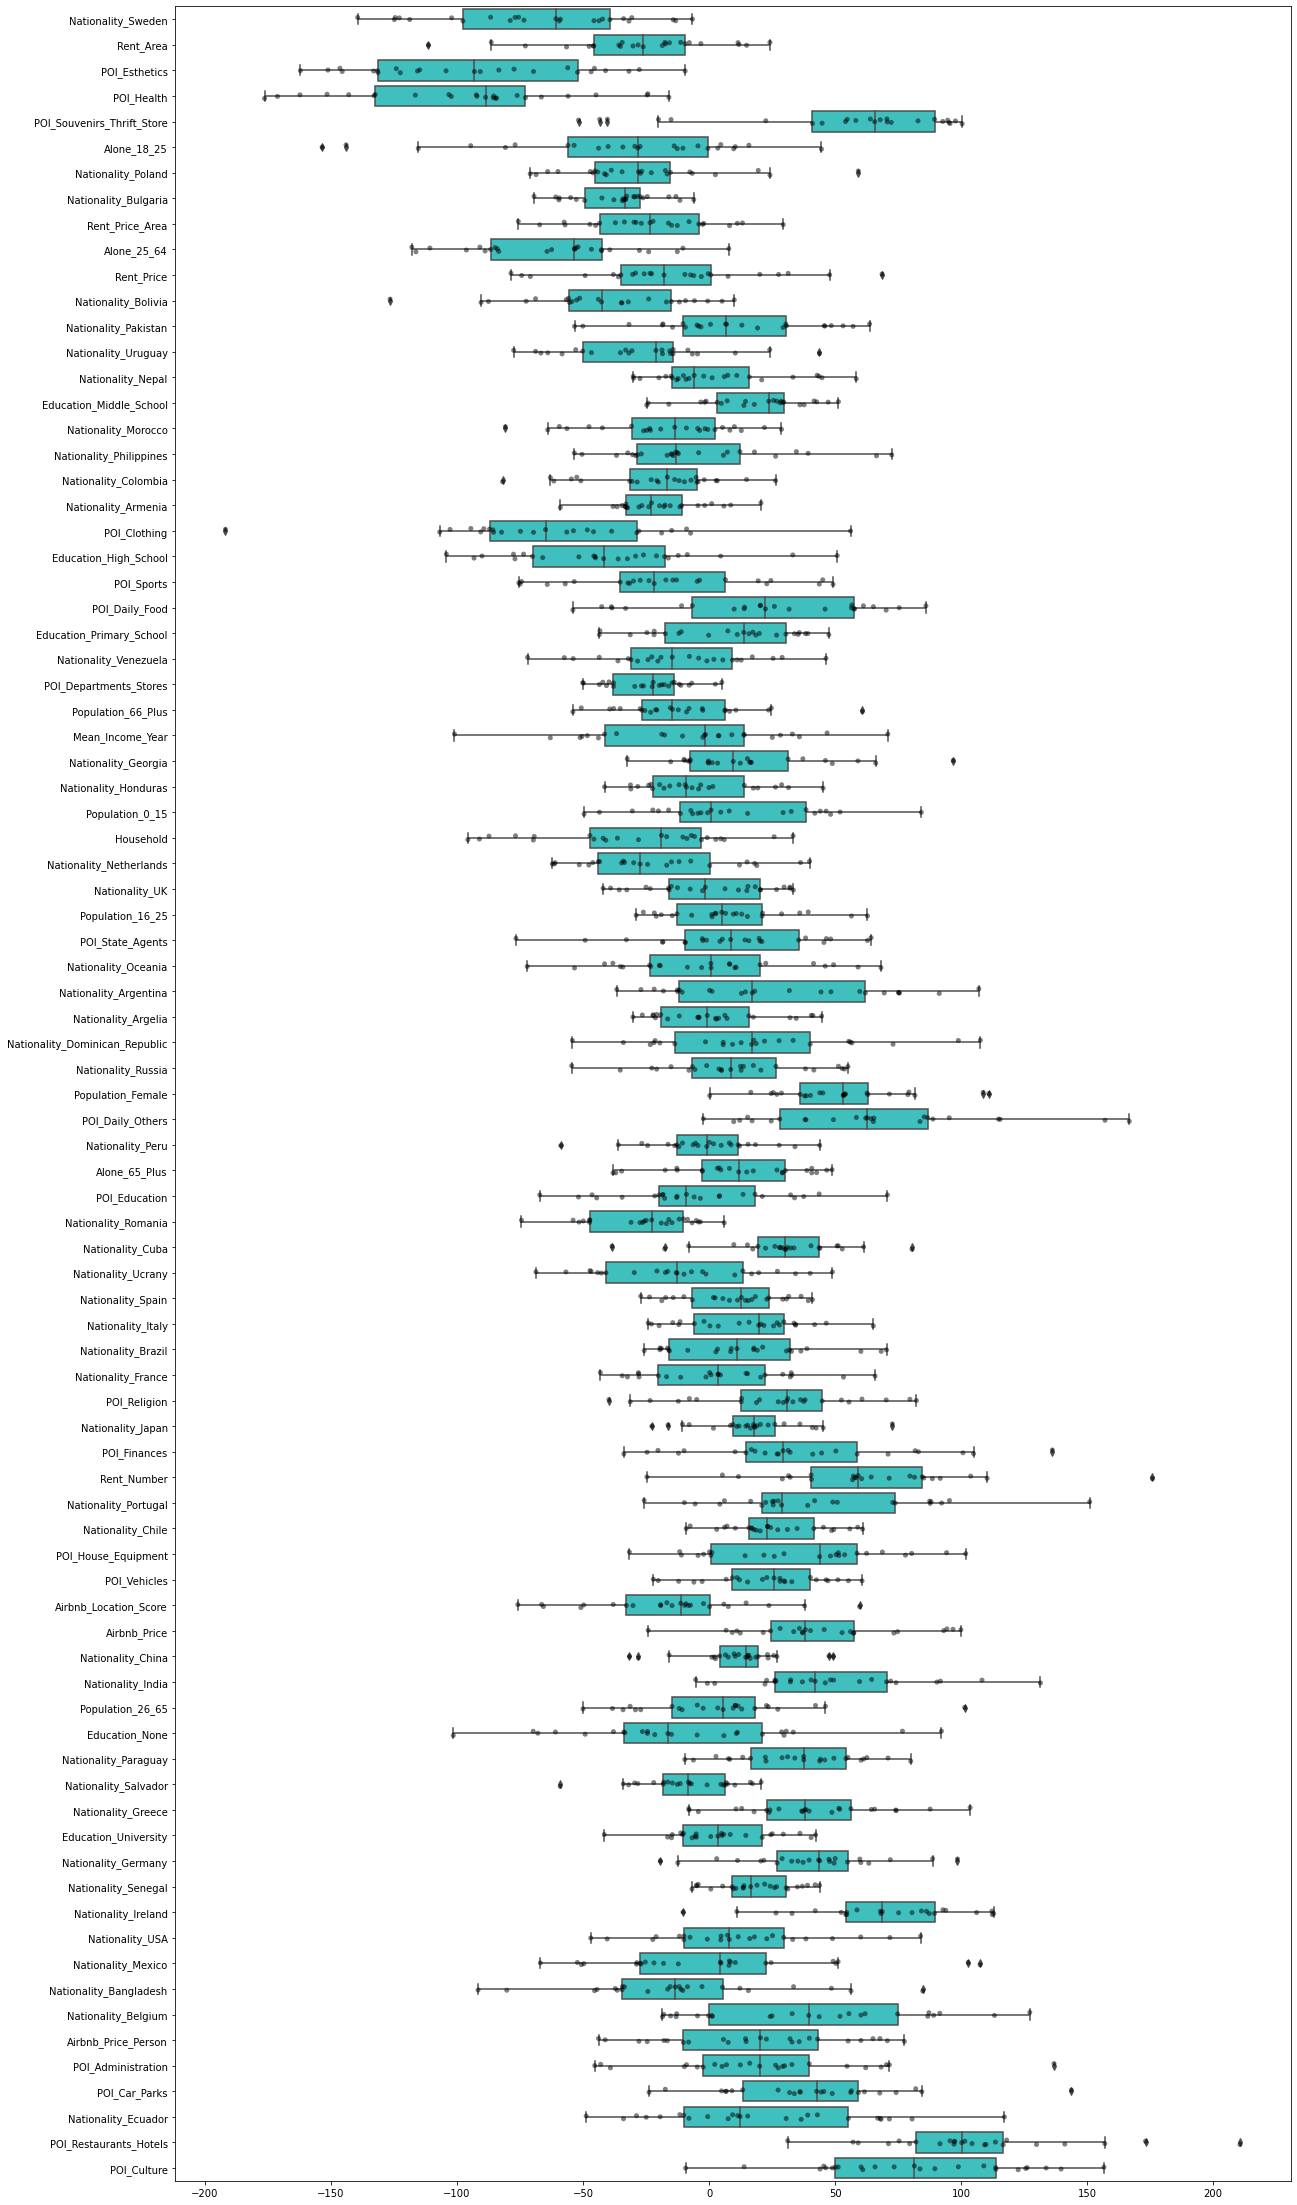

In [10]:
plt.figure(figsize=(20, 40))
sns.stripplot(data=new_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=new_coefs, orient='h', color='cyan', saturation=0.5)

# plt.savefig('sensibility.jpg')

In [11]:
mae_kfold = -cv_pipe['test_neg_median_absolute_error'].mean()
mse_kfold = -cv_pipe['test_neg_mean_squared_error'].mean()
r2_kfold = -cv_pipe['test_r2'].mean()

kfold_metrics = {'K-Fold': [mae_kfold, mse_kfold, r2_kfold]}
kfold_metrics = pd.DataFrame(data=kfold_metrics)
kfold_metrics.index=list(['MAE', 'MSE', 'R2'])
kfold_metrics

,K-Fold
MAE,129.773565
MSE,133861.636592
R2,0.644576


In [12]:
print("Metrics for Train and Test")
print(train_test_metrics)
print("\nMetrics for K-Fold")
print(kfold_metrics)

Metrics for Train and Test
            Train           Test
MAE  3.410605e-13     134.260445
MSE  2.969427e-25  381162.303025
R2   1.000000e+00      -1.233161

Metrics for K-Fold
            K-Fold
MAE     129.773565
MSE  133861.636592
R2        0.644576
